In [36]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits
import reproject as rp

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Sky - pysm

Nei notebook scritti fino ad ora, i pixel avevo size = 0.5 arcmin. Purtroppo in pysm la mappa viene creata sempre delle stesse dimensioni, si può solo scegliere il numero di pixel (dato da $12 nside^2$). Di conseguenza la size dei pixel dipende da quanti pixel ho. Con nside = 128 vengono grandi 27 arcmin, e tutta l'analisi delle mappe viene male perchè sono troppo grandi. Per avere una size simile a 0.5 arcmin, serve nside = 4096

In [37]:
nside = 4096

#Give pixel area given nside in square radians or square degrees.
pix_area_deg = hp.pixelfunc.nside2pixarea(4096, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin")

With nside = 4096, the pixel size is 0.8588716029543514 arcmin


In [38]:
# pysm sky
sky = pysm3.Sky(nside=4096, preset_strings=["d1", "s1"])

## Sky - fgbuster

Per fare la component separation alla fine mi serve un elemento di fgbuster del tipo (n_frequency, 3, n_pix), ma per trasformare le mappe da 1d a 2d per fare l'analisi mi serve un elemento di pysm del tipo (n_pix). Quindi creo il cielo con fgbuster, ma dallo strumento prendo solo una frequenza (in questo caso 100 GHz) in modo da avere un elemento (1, 3, n_pix), dove 3 rappresenta I, Q, U. In questo modo posso lavorare singolarmente su array 1d I, Q, U e alla fine posso riunirli facilmente in un elemento (1, 3, n_pix) per fare la component separation. 

In [39]:
# convert to fgbuster sky

instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[6:7, :]            #estraggo solo la frequenza 100 Ghz dallo strumento

freq

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


In [40]:
sky_fgb    = get_observation(freq, sky , nside=4096,noise=False, unit='uK_CMB')

print(np.shape(sky_fgb))

(1, 3, 201326592)


In [41]:
mappa = sky_fgb[0, :, :]


np.shape(mappa)

(3, 201326592)

In [42]:
I_map = mappa[0,:]
Q_map = mappa[1,:]
U_map = mappa[2,:]

np.shape(I_map)

(201326592,)

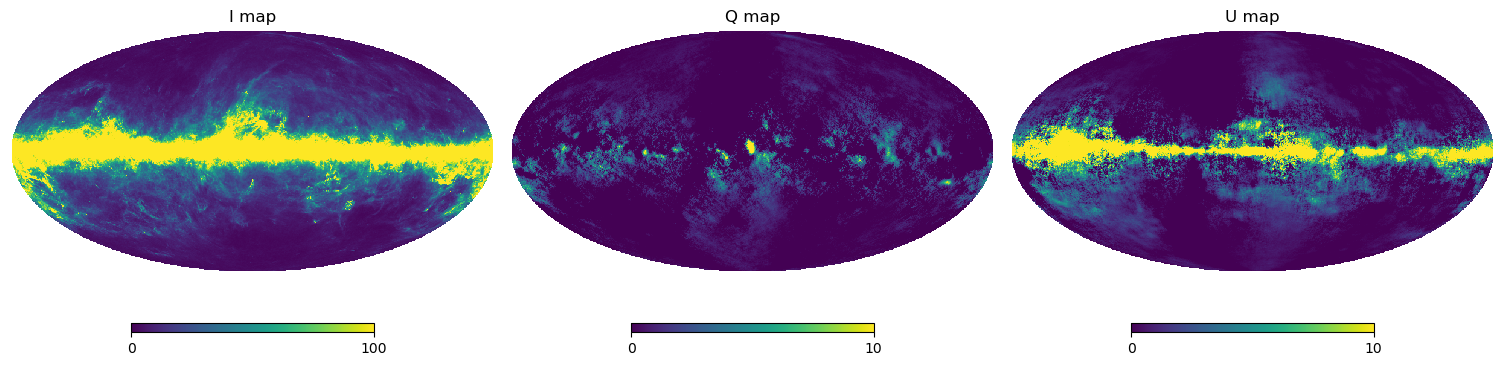

In [43]:
plt.figure(figsize=(15, 10))
hp.mollview(I_map, min=0, max=1e2, title="I map", sub=(1, 3, 1))
hp.mollview(U_map, min=0, max=1e1, title="Q map", sub=(1, 3, 2))
hp.mollview(Q_map, min=0, max=1e1, title="U map", sub=(1, 3, 3))
#hp.mollview(Pol_map, min=0, max=1e1, title="Pol map", unit=map_100GHz.unit, sub=(1, 4, 4))

### From galactic to celestial coordinates
https://github.com/aaroncnb/healpix_coordtrans_example/blob/master/hp_coordtrans_example.ipynb

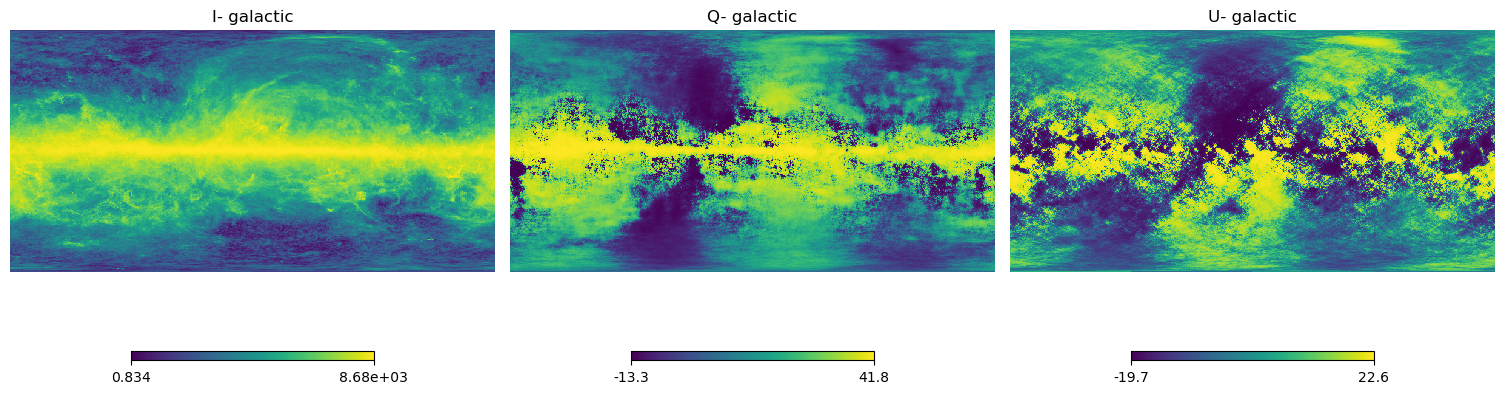

In [44]:
plt.figure(figsize=(15, 10))
hp.cartview(I_map, norm='hist', title="I- galactic", sub=(1, 3, 1))
hp.cartview(Q_map, norm='hist', title="Q- galactic", sub=(1, 3, 2))
hp.cartview(U_map, norm='hist', title="U- galactic", sub=(1, 3, 3))
#hp.cartview(Pol_map, norm='hist', title="Pol- galactic", sub=(1, 4, 4))

## NB
Passando a mappe 2d la dimensione totale della mappa cambia. Prima era un array 1D lungo 201326592, adesso è una mappa 2D di cui posso scegliere la lunghezza delle x mentre le y sono x/2. 
Scelgo x tale che $201326592 = Area_{mappa} = x * (\frac{x}{2})$, $x= 20066$. Trasformandola in 2D vengono fatte delle approssimazioni, quindi la mappa finale non ha 201326592 elementi ma 201322178.

Da quello che ho capito è solo una questione di rappresentazione della mappa, ma non voglio che cambi la size dei pixel.

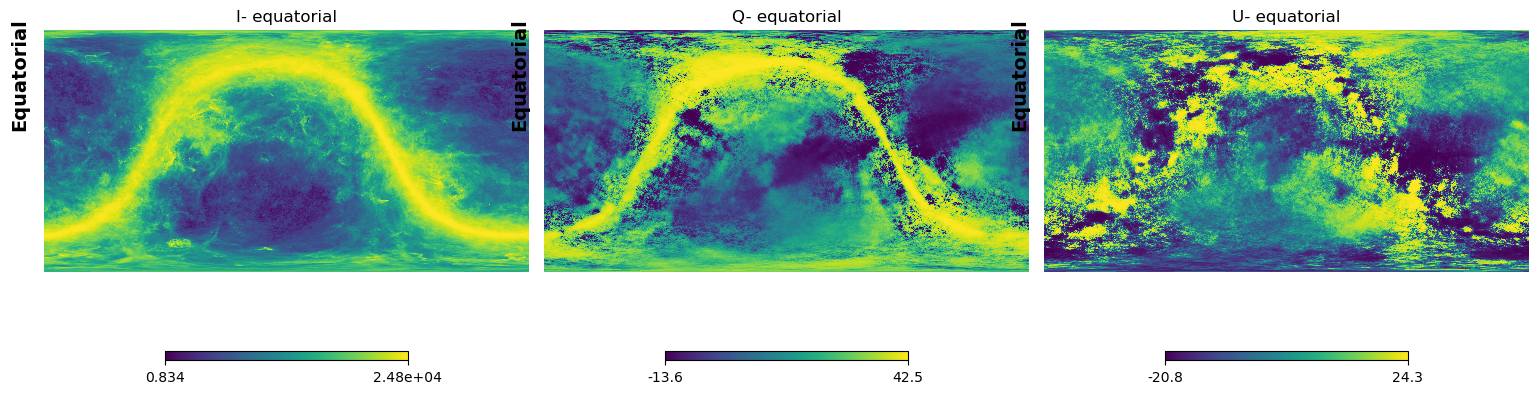

In [45]:
plt.figure(figsize=(15, 10))
I_cel   = hp.cartview(I_map, coord=['G','C'], return_projected_map=True, xsize=20066,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q_cel   = hp.cartview(Q_map, coord=['G','C'], return_projected_map=True, xsize=20066,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U_cel   = hp.cartview(U_map, coord=['G','C'], return_projected_map=True, xsize=20066,norm='hist', title="U- equatorial", sub=(1, 3, 3))
#Pol_cel = hp.cartview(Pol_map, coord=['G','C'], return_projected_map=True, xsize=800,norm='hist', title="Pol- equatorial", sub=(1, 4, 4))

In [46]:
I_cel = np.array(I_cel)
Q_cel = np.array(Q_cel)
U_cel = np.array(U_cel)
#Pol_cel = np.array(Pol_cel)

In [47]:
np.shape(I_cel)

(10033, 20066)

In [48]:
# quanto è grande un nuovo pixel? 
print(f"Un pixel della mappa 1D gande 201326592 ha size = {pix_size} arcmin")

# nuovo - # proporzione (non so se serva, cambia poco) 
pix_size = (10033*20066*pix_size)/(201322178) # proporzione (non so se serva) 
print(f"Un pixel della mappa 1D gande 201322178 ha size = {pix_size} arcmin")

Un pixel della mappa 1D gande 201326592 ha size = 0.8588716029543514 arcmin
Un pixel della mappa 1D gande 201322178 ha size = 0.8588716029543515 arcmin


### Save the maps

In [49]:
'''
# CAMBIARE NAXIS1 E 2 IN BASE ALLE DIMENSIONI DELLE MAPPE !!!!!!!!!!!!!!
target_header = fits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  20066
NAXIS2  =                  10033
CTYPE1  = 'GLON-CAR'
CRPIX1  =                  400
CRVAL1  =                  0.0
CDELT1  =                 -0.450000
CUNIT1  = 'deg     '
CTYPE2  = 'GLAT-CAR'
CRPIX2  =                  200
CRVAL2  =                  0.0
CDELT2  =                  0.4500000
CUNIT2  = 'deg     '
COORDSYS= 'GALACTIC'
""", sep='\n')  


I_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((I_cel, target_header), coord_system_out= 'GALACTIC', nside=4096, nested=False)
Q_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((Q_cel, target_header), coord_system_out= 'GALACTIC', nside=4096, nested=False)
U_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((U_cel, target_header), coord_system_out= 'GALACTIC', nside=4096, nested=False)
#Pol_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((Pol_cel, target_header), coord_system_out= 'GALACTIC', nside=512, nested=False)

hp.write_map("I_cel.fits",I_cel_HP, coord='C',overwrite=True)
hp.write_map("Q_cel.fits",Q_cel_HP, coord='C',overwrite=True)
hp.write_map("U_cel.fits",U_cel_HP, coord='C',overwrite=True)
#hp.write_map("Pol_cel.fits",Pol_cel_HP, coord='C',overwrite=True)

'''

'\n# CAMBIARE NAXIS1 E 2 IN BASE ALLE DIMENSIONI DELLE MAPPE !!!!!!!!!!!!!!\ntarget_header = fits.Header.fromstring("""\nNAXIS   =                    2\nNAXIS1  =                  20066\nNAXIS2  =                  10033\nCTYPE1  = \'GLON-CAR\'\nCRPIX1  =                  400\nCRVAL1  =                  0.0\nCDELT1  =                 -0.450000\nCUNIT1  = \'deg     \'\nCTYPE2  = \'GLAT-CAR\'\nCRPIX2  =                  200\nCRVAL2  =                  0.0\nCDELT2  =                  0.4500000\nCUNIT2  = \'deg     \'\nCOORDSYS= \'GALACTIC\'\n""", sep=\'\n\')  \n\n\nI_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((I_cel, target_header), coord_system_out= \'GALACTIC\', nside=4096, nested=False)\nQ_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((Q_cel, target_header), coord_system_out= \'GALACTIC\', nside=4096, nested=False)\nU_cel_HP, footprint_Gal_HP = rp.reproject_to_healpix((U_cel, target_header), coord_system_out= \'GALACTIC\', nside=4096, nested=False)\n#Pol_cel_HP, footprint_G

In [50]:
fits.writeto("I", I_cel, overwrite=True)
fits.writeto("Q", Q_cel, overwrite=True)
fits.writeto("U", U_cel, overwrite=True)

## READ the maps 

In [51]:
I_2d = fits.getdata("I")
Q_2d = fits.getdata("Q")
U_2d = fits.getdata("U")

In [52]:
np.shape(I_2d)

(10033, 20066)

**NB**: è del tipo (y, x)

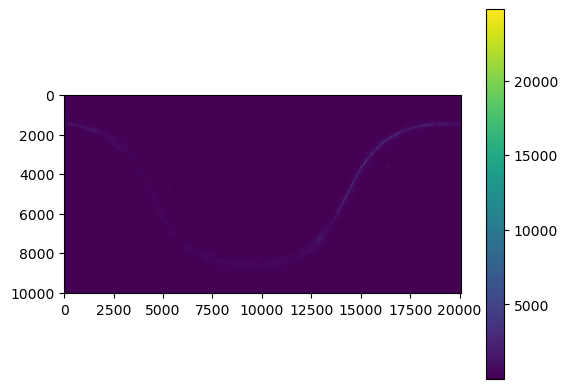

In [53]:
plt.imshow(I_2d, cmap='viridis') 
plt.colorbar() 
plt.show()

## Sky Patch in 2d

**NB:** La patch deve avere dimensioni tali che in 1d (quindi se è una matrice x,y, il prodotto x*y) deve essere del tipo $(nside^2)*12$ o quando si riconverte in 1d non si riesce a rappresentare con healpy e non si riesce a fare la component separation

Questo significa che se io voglio una patch NxN (come di solito rappresento le mappe) ho che $N^2 = (nside^2)*12$, quindi $N = \sqrt{(nside^2)*12}$.

Ma sia $N$ che $nside$ devono essere interi, e non è possibile. Di conseguenza **la patch non può essere quadrata (NxN) se lavoro con fgbuster!!!**


In [55]:
# un pixels healpy è grande..
pix_size # arcmin

# in degrees
pix_size_deg_new = pix_size / 60
pix_size_deg_new

0.014314526715905858

In [56]:
# trovo il numero totale di pixel, Nx * Ny = 12 * (nside**2)
nside_patch = 200

N_full = 12 *( nside_patch**2)# number of pixels, full map
N_full

480000

In [57]:
# ora devo trovare un Ny e Nx che moltiplicati diano N_full. Devono essere interi

Nx = 600
Ny = 800

Nx * Ny

480000

In [58]:
# un pixels healpy in degrees
pix_size_deg_new = pix_size / 60


X_width = Nx * pix_size_deg
Y_width = Ny * pix_size_deg


# color map
c_min, c_max     = -10, 10      


print(f"Patch con {Nx} x {Ny} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")


#nbig = 5000

Patch con 600 x 800 pixels, ognuno di 0.8588716029543515 arcmin, per una dimensione totale di 8.59 x 11.45 gradi


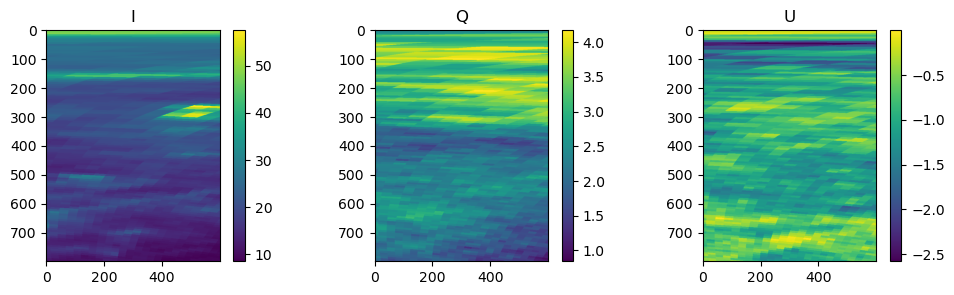

In [59]:
# CREAZIONE PATCH (y, x)
I_patch     = I_2d[0:0+Ny, 7500:7500+Nx]
Q_patch     = Q_2d[0:0+Ny, 7500:7500+Nx]
U_patch     = U_2d[0:0+Ny, 7500:7500+Nx]


maps = [I_patch, Q_patch, U_patch]
title = ['I', 'Q', 'U']

# Visualizza le mappe in una griglia 2x2
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
        im =axs[i].imshow(maps[i], cmap='viridis')  # cmap è la mappa di colori, puoi cambiare in base alle tue preferenze
        axs[i].set_title(title[i])
        cbar = fig.colorbar(im, ax=axs[i])#, aspect=5)

plt.show()

In [60]:
# SALVO LE PATCH
fits.writeto("I_patch", I_patch, overwrite=True)
fits.writeto("Q_patch", Q_patch, overwrite=True)
fits.writeto("U_patch", U_patch, overwrite=True)